In [1]:
from copy import deepcopy
from typing import List

import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

from src.models.geometric_figure import GeometricFigure
from src.services.geometric_figure import (get_geometric_figures,
                                           get_input_and_output,
                                           plot_geometric_figures,
                                           prediction_to_category)

In [2]:
IMAGE_SIZE = (512, 512)
TEST_RATIO = 0.2
DATA_VERSION = '2023-03-22'

In [3]:
geometric_figures: List[GeometricFigure] = get_geometric_figures(f'data/{DATA_VERSION}', IMAGE_SIZE, memorize=True)
print(f'Loaded {len(geometric_figures)} geometric figures')

Loaded 300 geometric figures


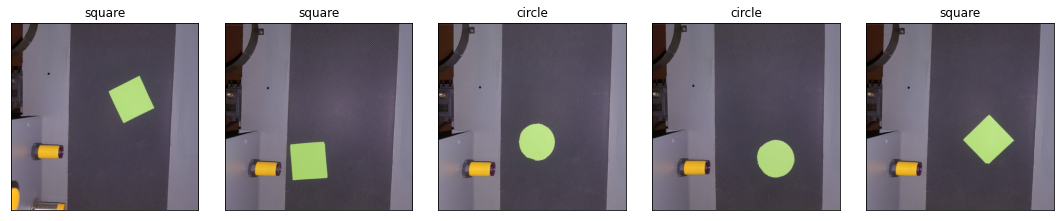

In [4]:
number_of_plots = 5
random_geometric_figures = [geometric_figures[i] for i in np.random.randint(0, len(geometric_figures), number_of_plots)]
plot_geometric_figures(random_geometric_figures, number_of_plots)
plt.show()

Verificação dos canais de cor da imagem para identificar o canal de maior importância

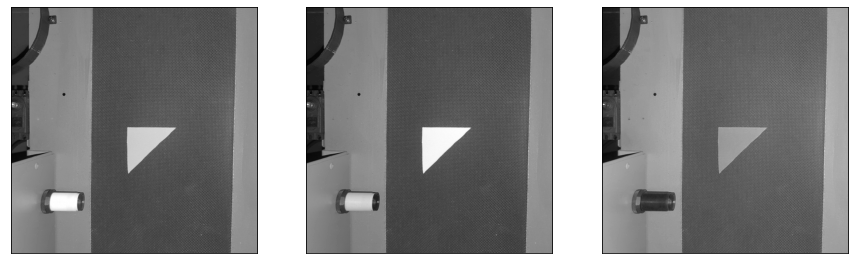

In [5]:
def plot_separate_color_channels_image(image: np.ndarray) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    for i in range(3):
        axs[i].imshow(image[:, :, i], cmap='gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.patch.set_facecolor('white')

image = geometric_figures[np.random.randint(0, len(geometric_figures))]['image']
plot_separate_color_channels_image(image)
plt.show()

In [6]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    keras.layers.Lambda(lambda x: x[..., 1:2]),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 1)       0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 33,564,995
Trainable params: 33,564,995
Non-trainable params: 0
____________________________________________

In [7]:
shuffled_geometric_figures: List[GeometricFigure] = deepcopy(geometric_figures)
np.random.shuffle(shuffled_geometric_figures)

x, y = zip(*[get_input_and_output(gf) for gf in shuffled_geometric_figures])
x = np.array(x)
y = np.array(y)

test_size = int(len(x) * TEST_RATIO)
x_train, x_test = x[:-test_size], x[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

In [8]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
8/8 [==============================] - 2s 169ms/step - loss: 39.8495 - accuracy: 0.3750
Epoch 2/20
8/8 [==============================] - 1s 168ms/step - loss: 5.3935 - accuracy: 0.3625
Epoch 3/20
8/8 [==============================] - 1s 169ms/step - loss: 4.6684 - accuracy: 0.4542
Epoch 4/20
8/8 [==============================] - 1s 140ms/step - loss: 3.0845 - accuracy: 0.4458
Epoch 5/20
8/8 [==============================] - 1s 150ms/step - loss: 1.8076 - accuracy: 0.4375
Epoch 6/20
8/8 [==============================] - 1s 139ms/step - loss: 2.3065 - accuracy: 0.4917
Epoch 7/20
8/8 [==============================] - 1s 140ms/step - loss: 1.7186 - accuracy: 0.5958
Epoch 8/20
8/8 [==============================] - 1s 136ms/step - loss: 0.7149 - accuracy: 0.6792
Epoch 9/20
8/8 [==============================] - 1s 143ms/step - loss: 0.8188 - accuracy: 0.6542
Epoch 10/20
8/8 [==============================] - 1s 141ms/step - loss: 0.4900 - accuracy: 0.8042
Epoch 11/20
8/8 [=

In [9]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 33ms/step - loss: 0.3424 - accuracy: 0.9167


[0.3423561155796051, 0.9166666865348816]

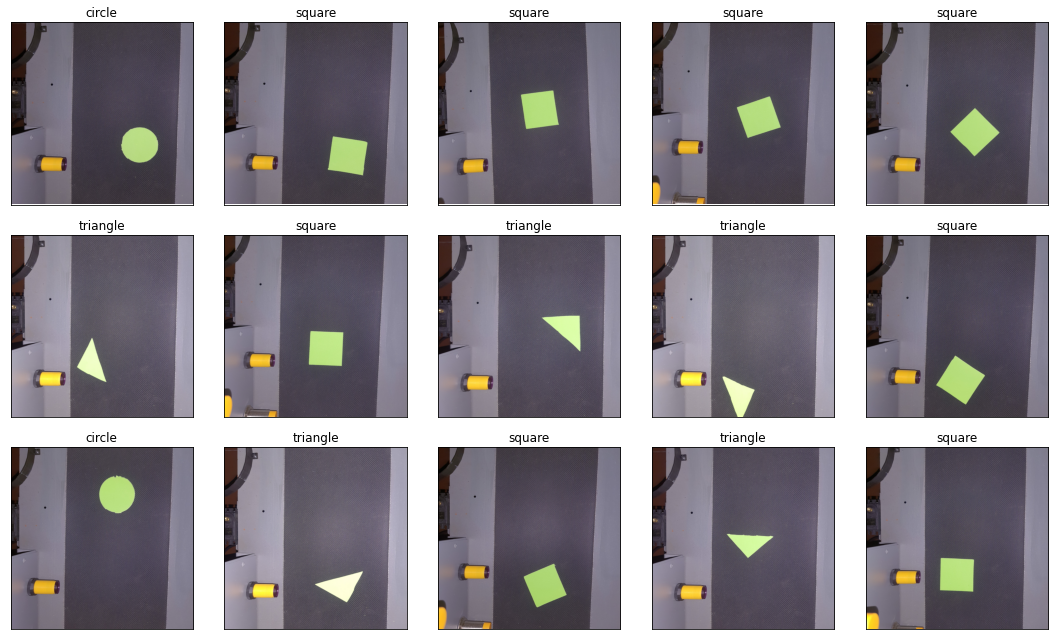

In [10]:
number_of_plots = 15
random_geometric_figures = deepcopy([geometric_figures[i] for i in np.random.randint(0, len(geometric_figures), number_of_plots)])
for gf in random_geometric_figures:
    x, y = get_input_and_output(gf)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    category = prediction_to_category(y_pred)
    gf['category'] = category
plot_geometric_figures(random_geometric_figures, columns=5, plot_size=3)
plt.show()

In [11]:
model.save('data/geometric_figure_classifier.h5')